In [2]:
!apt-get install python-opengl -y

!apt install xvfb -y
!pip install gym[box2d]
!pip install pyvirtualdisplay

!pip install piglet

!pip install gym[atari]
!pip install gym[accept-rom-license]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  freeglut3 libglu1-mesa libpython2-stdlib libpython2.7-minimal
  libpython2.7-stdlib python2 python2-minimal python2.7 python2.7-minimal
Suggested packages:
  python-tk python-numpy libgle3 python2-doc python2.7-doc binfmt-support
The following NEW packages will be installed:
  freeglut3 libglu1-mesa libpython2-stdlib libpython2.7-minimal
  libpython2.7-stdlib python-opengl python2 python2-minimal python2.7
  python2.7-minimal
0 upgraded, 10 newly installed, 0 to remove and 76 not upgraded.
Need to get 4540 kB of archives.
After this operation, 22.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 libpython2.7-minimal amd64 2.7.18-1~20.04.3 [336 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 python2.7-minimal amd64 2.7.18-1~20.04.3 [1280 kB]
Get:3 http:/

In [3]:
import cv2
import numpy as np
import random
import numpy as np
from collections import deque
import gym
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import disable_interactive_logging



from pyvirtualdisplay import Display
Display().start()
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
#This function takes an image frame (in BGR color format) and converts it to grayscale, converts the pixel values to floats, and scales them between 0 and 1.
def process_state_image(state):
    state = cv2.cvtColor(state, cv2.COLOR_BGR2GRAY)# Convert the image to grayscale
    state = state.astype(float)# Convert the pixel values to floats
    state /= 255.0 # Scale the pixel values between 0 and 1
    return state

#This function takes a deque object and converts it into a numpy array. 
#It then transposes the array from (stack, x, y) to (x, y, stack) so that the frames in the deque are stacked along the channel dimension.

def generate_state_frame_stack_from_queue(deque):
    frame_stack = np.array(deque)# Convert the deque to a NumPy array
    # Move stack dimension to the channel dimension (stack, x, y) -> (x, y, stack)
    return np.transpose(frame_stack, (1, 2, 0))

/opt/conda/lib/python3.7/site-packages/botocore/httpsession.py:41: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from urllib3.contrib.pyopenssl import orig_util_SSLContext as SSLContext


In [4]:
class CarRacingDQNAgent:
    # Initialize class attributes with default values and build neural network models
    def __init__(
        self,
        action_space    = [
            (-1, 1, 0.2), (0, 1, 0.2), (1, 1, 0.2), #           Action Space Structure
            (-1, 1,   0), (0, 1,   0), (1, 1,   0), #        (Steering Wheel, Gas, Break)
            (-1, 0, 0.2), (0, 0, 0.2), (1, 0, 0.2), # Range        -1~1       0~1   0~1
            (-1, 0,   0), (0, 0,   0), (1, 0,   0)
        ],
        frame_stack_num = 3,
        memory_size     = 5000,
        gamma           = 0.95,  # discount rate
        epsilon         = 1.0,   # exploration rate
        epsilon_min     = 0.1,
        epsilon_decay   = 0.9999,
        learning_rate   = 0.001
    ):
        self.action_space    = action_space # Set action space
        self.frame_stack_num = frame_stack_num # Set frame stack size
        self.memory          = deque(maxlen=memory_size)  # Set deque with max length for memory
        self.gamma           = gamma # Set discount rate for future rewards
        self.epsilon         = epsilon # Set exploration rate
        self.epsilon_min     = epsilon_min # Set minimum exploration rate
        self.epsilon_decay   = epsilon_decay # Set exploration rate decay
        self.learning_rate   = learning_rate # Set learning rate for neural network
        self.model           = self.build_model() # Build neural network model
        self.target_model    = self.build_model() #Build the target model
        #Update target neural network model with the same weights as neural network model
        self.update_target_model()

    def build_model(self):
        # Building the Neural Net for Deep-Q learning Model with 2 CNN Layers, 2 Max Pooling Layers, 1 Flattening Layer and 2 Dense Layers 
        model = Sequential()
        model.add(Conv2D(filters=6, kernel_size=(7, 7), strides=3, activation='relu', input_shape=(96, 96, self.frame_stack_num)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(filters=12, kernel_size=(4, 4), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(216, activation='relu'))
        model.add(Dense(len(self.action_space), activation=None))
        model.compile(loss='mean_squared_error', optimizer=Adam(lr=self.learning_rate, epsilon=1e-7))
        return model
    #This function updates the weights of the target model with the current weights of the main model.
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    #This function stores the state, action, reward, next_state, and done information of an experience in memory.
    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, self.action_space.index(action), reward, next_state, done))
    
    #This function selects an action based on the current state.
    def act(self, state):
        if np.random.rand() > self.epsilon:
            act_values = self.model.predict(np.expand_dims(state, axis=0))
            action_index = np.argmax(act_values[0])
        else:
            action_index = random.randrange(len(self.action_space))
        return self.action_space[action_index]

    #This function trains the main model using experiences from memory. 
    #It samples a batch of experiences and calculates the target Q-values using the Bellman equation
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        train_state = []
        train_target = []
        for state, action_index, reward, next_state, done in minibatch:
            target = self.model.predict(np.expand_dims(state, axis=0))[0]
            if done:
                target[action_index] = reward
            else:
                t = self.target_model.predict(np.expand_dims(next_state, axis=0))[0]
                target[action_index] = reward + self.gamma * np.amax(t)
            train_state.append(state)
            train_target.append(target)
        self.model.fit(np.array(train_state), np.array(train_target), epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    #This function loads the weights of the main model from a file and updates the weights of the target model accordingly.
    def load(self, name):
        self.model.load_weights(name)
        self.update_target_model()
    #This function saves the weights of the target model to a file.
    def save(self, name):
        self.target_model.save_weights(name)

In [5]:
disable_interactive_logging()

In [6]:
import time

if __name__ == '__main__':
    env = gym.make('CarRacing-v1')
    epsilon =1.0
    #creates an instance of the CarRacingDQNAgent class and initializes it with an epsilon value of 1.0.
    agent = CarRacingDQNAgent(epsilon=epsilon)
    STARTING_EPISODE = 1
    ENDING_EPISODE = 17
    SKIP_FRAMES  = 10
    TRAINING_BATCH_SIZE           = 32
    SAVE_TRAINING_FREQUENCY       = 25
    UPDATE_TARGET_MODEL_FREQUENCY = 5

    episode_durations = []
    #This runs for each episode, resetting the environment and the agent at the start of each episode
    for e in range(STARTING_EPISODE, ENDING_EPISODE+1):
        init_state = env.reset()
        init_state = process_state_image(init_state)

        total_reward = 0
        training_rewards=[]
        negative_reward_counter = 0
        #observed by the agent in a sliding window fashion, so that the agent can build a sequence of frames that can be fed into the neural network for training or prediction purposes.
        state_frame_stack_queue = deque([init_state]*agent.frame_stack_num, maxlen=agent.frame_stack_num)
        time_frame_counter = 1
        done = False

        start_time = time.time()
        
        while True:
            # if RENDER:
            #     env.render()

            current_state_frame_stack = generate_state_frame_stack_from_queue(state_frame_stack_queue)
            action = agent.act(current_state_frame_stack)

            reward = 0
            #During each iteration, the environment advances one step based on the selected action
            #Returns a tuple containing the next state of the environment (next_state)
            for _ in range(SKIP_FRAMES+1):
                next_state, r, done, info = env.step(action)
                reward += r
                if done:
                    break

            # If continually getting negative reward 10 times after the tolerance steps, terminate this episode
            negative_reward_counter = negative_reward_counter + 1 if time_frame_counter > 100 and reward < 0 else 0

            # Extra bonus for the model if it uses full gas
            if action[1] == 1 and action[2] == 0:
                reward *= 1.5

            training_rewards.append(reward)
            total_reward += reward
            
            #next_state image received from the environment is preprocessed using the process_state_image function. 
            #The preprocessed image is added to the state_frame_stack_queue, which is a queue containing the most recent n preprocessed image frames (where n is the frame_stack_num attribute of the agent).
            next_state = process_state_image(next_state)
            state_frame_stack_queue.append(next_state)
            next_state_frame_stack = generate_state_frame_stack_from_queue(state_frame_stack_queue)

            agent.memorize(current_state_frame_stack, action, reward, next_state_frame_stack, done)
            # If negative_reward_counter >= 25 This means that the car has received negative rewards for too long
            #'done': This means that the episode is finished and the car has crashed or reached the finish line.
            #If total_reward<0 This means that the car has performed very poorly in the episode.
            if done or negative_reward_counter >= 25 or total_reward < 0:
                duration = time.time() - start_time
                print('Episode: {}/{}, Scores(Time Frames): {}, Total Rewards(adjusted): {:.2}, Epsilon: {:.2}, Duration: {:.2f}'.format(e, ENDING_EPISODE, time_frame_counter, float(total_reward), float(agent.epsilon), duration))
                episode_durations.append(duration)
                break
            if len(agent.memory) > TRAINING_BATCH_SIZE:
                agent.replay(TRAINING_BATCH_SIZE)
            time_frame_counter += 1

        if e % UPDATE_TARGET_MODEL_FREQUENCY == 0:
            agent.update_target_model()

        if e % SAVE_TRAINING_FREQUENCY == 0:
            agent.save('./save/trial_{}.h5'.format(e))


Track generation: 1129..1415 -> 286-tiles track
Episode: 1/17, Scores(Time Frames): 30, Total Rewards(adjusted): -0.11, Epsilon: 1.0, Duration: 5.59
Track generation: 1196..1500 -> 304-tiles track
Episode: 2/17, Scores(Time Frames): 19, Total Rewards(adjusted): -1.1, Epsilon: 1.0, Duration: 62.21
Track generation: 991..1243 -> 252-tiles track
Episode: 3/17, Scores(Time Frames): 91, Total Rewards(adjusted): 5.3e+01, Epsilon: 0.99, Duration: 303.79
Track generation: 1060..1337 -> 277-tiles track
Episode: 4/17, Scores(Time Frames): 39, Total Rewards(adjusted): -0.037, Epsilon: 0.99, Duration: 128.88
Track generation: 1167..1463 -> 296-tiles track
Episode: 5/17, Scores(Time Frames): 57, Total Rewards(adjusted): -1.5, Epsilon: 0.98, Duration: 190.72
Track generation: 1162..1457 -> 295-tiles track
Episode: 6/17, Scores(Time Frames): 27, Total Rewards(adjusted): -0.69, Epsilon: 0.98, Duration: 87.90
Track generation: 1144..1434 -> 290-tiles track
Episode: 7/17, Scores(Time Frames): 30, Total 

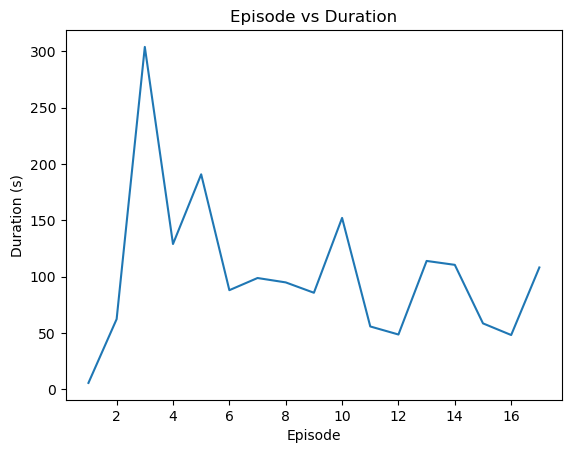

In [7]:
import matplotlib.pyplot as plt

plt.plot(range(STARTING_EPISODE, ENDING_EPISODE+1), episode_durations)
plt.xlabel('Episode')
plt.ylabel('Duration (s)')
plt.title('Episode vs Duration')
plt.show()


In [8]:
# This function evaluates the performance of an agent in a given environment for a number of episodes.
# It takes as inputs the agent object, the environment object and the number of episodes to evaluate.
def evaluate_agent(agent, env, num_episodes):
    # A list to hold the total reward obtained in each episode is initialized.
    total_rewards = []
    # For each episode:
    for i in range(num_episodes):
        # The initial state of the environment is reset.
        state = env.reset()
        # The initial state is preprocessed.
        state = process_state_image(state)
        # The preprocessed state is stacked n times (where n is the number of frames the agent can see at once) along the third dimension.
        state = np.stack([state]*agent.frame_stack_num, axis=2)
        # The total reward obtained in this episode is initialized.
        total_reward = 0
        # A flag indicating whether the episode is finished or not is set to False.
        done = False
        # While the episode is not finished:
        while not done:
            # The agent selects an action based on the current state.
            action = agent.act(state)
            # The environment is stepped with the selected action.
            next_state, reward, done, _ = env.step(action)
            # The resulting next state is preprocessed.
            next_state = process_state_image(next_state)
            # The preprocessed next state is appended to the end of the state array along the third dimension, and the first state is dropped.
            next_state = np.append(state[:, :, 1:], np.expand_dims(next_state, 2), axis=2)
            # The next state becomes the current state.
            state = next_state
            # The reward obtained in this step is added to the total reward of the episode.
            total_reward += reward
        # The total reward obtained in this episode is added to the list of total rewards.
        total_rewards.append(total_reward)
    # The average reward obtained over all episodes is calculated.
    avg_reward = sum(total_rewards) / num_episodes  
    # The average reward is returned as the output of the function.
    return avg_reward


In [9]:
#Mapping the test results for 10 iterations
test_env = gym.make('CarRacing-v1')
test_rewards = []
for i in range(10):
    reward = evaluate_agent(agent, test_env, num_episodes=10)
    test_rewards.append(reward)

Track generation: 1236..1549 -> 313-tiles track
Track generation: 1143..1433 -> 290-tiles track
Track generation: 1268..1596 -> 328-tiles track
Track generation: 1131..1427 -> 296-tiles track
Track generation: 1203..1508 -> 305-tiles track
Track generation: 1035..1298 -> 263-tiles track
Track generation: 1022..1287 -> 265-tiles track
Track generation: 1163..1458 -> 295-tiles track
Track generation: 1185..1485 -> 300-tiles track
Track generation: 1160..1454 -> 294-tiles track
Track generation: 1079..1353 -> 274-tiles track
Track generation: 1245..1569 -> 324-tiles track
Track generation: 1191..1493 -> 302-tiles track
Track generation: 1220..1529 -> 309-tiles track
Track generation: 1255..1573 -> 318-tiles track
Track generation: 1229..1540 -> 311-tiles track
Track generation: 1135..1423 -> 288-tiles track
Track generation: 1308..1639 -> 331-tiles track
Track generation: 1199..1503 -> 304-tiles track
Track generation: 1141..1430 -> 289-tiles track
Track generation: 1243..1558 -> 315-tile

In [10]:
test_rewards

[-28.486669552383198,
 -30.467610638971045,
 -25.49638257870337,
 -21.91934072501371,
 -25.881135655301286,
 -23.654700815665695,
 -31.007627451965988,
 -36.50240652161568,
 -32.37621557320544,
 -26.967635905958936]

In [13]:
training_rewards

[14.479032258064525,
 -1.6499999999999941,
 6.068458781362011,
 9.10268817204299,
 6.06845878136199,
 -1.1000000000000156,
 -1.1000000000000156,
 -1.1000000000000156,
 -1.6500000000000234,
 -1.1000000000000156,
 -1.1000000000000156,
 -1.1000000000000156,
 -1.6500000000000234,
 -1.6500000000000234,
 -1.1000000000000103,
 -1.099999999999996,
 -1.6499999999999941,
 -1.099999999999996,
 -1.099999999999996,
 -1.099999999999996,
 -1.099999999999996,
 -1.099999999999996,
 -1.099999999999996,
 -1.099999999999996,
 -1.099999999999996,
 -1.0999999999999979,
 -1.100000000000001,
 -1.100000000000001,
 -1.1,
 -1.1,
 -1.6500000000000012,
 -1.6500000000000012,
 -1.100000000000001]

In [12]:
total_reward

-0.0313620071686187

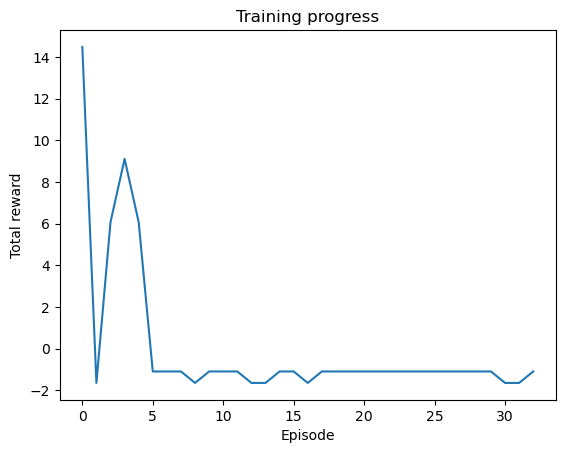

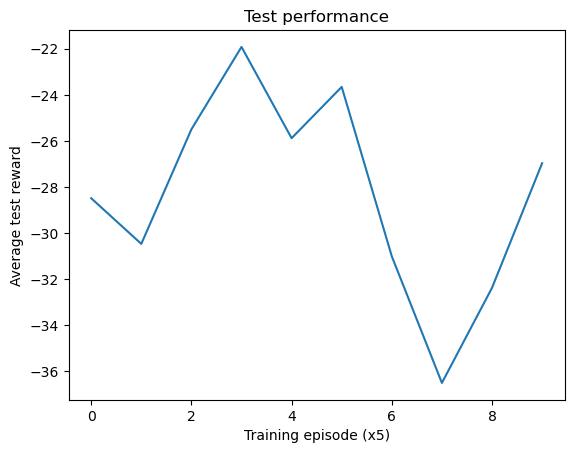

In [15]:
import matplotlib.pyplot as plt
#Plotting a map against the Training Rewards and Test Rewards

plt.plot(training_rewards)
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.title('Training progress')
plt.show()

plt.plot(test_rewards)
plt.xlabel('Training episode (x5)')
plt.ylabel('Average test reward')
plt.title('Test performance')
plt.show()


In [ ]:
test_rewards